<a href="https://colab.research.google.com/github/necatiemre/derino-renme/blob/main/derin%C3%B6%C4%9Frenmeat%C4%B1lacaksonhali_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1_adl%C4%B1_not_defterinin_kopyas%C4%B1_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader ,random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import zipfile

In [ ]:
data_unzip = zipfile.ZipFile('/content/train (1).zip', 'r')
data_unzip.extractall()
data_unzip.close()

In [ ]:
class DatasetFromList(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [ ]:
data_dir = '/content/train'

# ImageFolder tüm görüntüleri klasör isimlerinden yola çıkarak otomatik etiketler.
dataset = datasets.ImageFolder(root=data_dir, transform=None)

# Burada başlangıçta transform = None verdik-, böylece asıl transform eğitim/test verilerine ayrıldıktan sonra uygulanacak.

In [ ]:
train_data, test_data = train_test_split(dataset.imgs, test_size=0.2, stratify=[y[1] for y in dataset.imgs])
# Burada veri setini %80, test setini %20 olarak ayarlıyoruz.

train_dataset = DatasetFromList(train_data, transform=transform)
test_dataset = DatasetFromList(test_data, transform=transform)
# Burada ayrılan listeleri farklı adlandırıp transform ediyoruz.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Burada eğitim setini batch halinde karıştırmasını istediğimiz için shuffle değerini true yapıyoruz.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # Giriş: 3x128x128, Çıkış: 64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Çıkış: 128x32x32
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# Çıkış: 256x16x16
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 128x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # 3x128x128
            nn.Sigmoid() # Çıkış değerlerini [0,1] aralığına sıkıştır
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# Autoencoder modeli giriş görüntüsünü kademeli olarak küçük bir latent temsile encode eder. Ardından bu temsil üzerinden görüntüyü yeniden oluşturur (decode).
# Encoder kısmı konvolüsyonlar ile uzamsal boyutları küçültür, kanal sayısını artırır.
# Decoder kısmı transpoze konvolüsyonlarla boyutları geri büyütür.
# Sigmoid ile çıkış pixel değerleri 0 ile 1 arasına getirilir.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)
# GPU mevcutsa CUDA kullanılır, yoksa CPU.


In [ ]:
optimizer = optim.AdamW(autoencoder.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# AdamW optimizer, klasik Adam’a benzer ancak ağırlık çürümesini (weight decay) farklı işler.
# lr=1e-3 başlangıç öğrenme hızı.
# CosineAnnealingLR: 10 epoch boyunca öğrenme hızı kosinüs şeklinde azalacak.


In [ ]:
num_epochs = 100
criterion = nn.MSELoss()  # Yeniden oluşturma hatası için MSE

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()

        # İleri geçiş
        outputs = autoencoder(inputs)

        # Kayıp (loss) hesaplama
        loss = criterion(outputs, inputs)
        loss.backward()  # Geri yayılım
        optimizer.step() # Ağırlıkları güncelle

        running_loss += loss.item()
        # Her 100 batch'te bir ara çıktı yazdır
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], Loss: {loss.item()}")

    # Scheduler adım atar (öğrenme hızını günceller)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/100], Batch [0], Loss: 0.05420961603522301
Epoch [1/100], Batch [100], Loss: 0.00825999490916729
Epoch [1/100], Loss: 0.016536949895885136
Epoch [2/100], Batch [0], Loss: 0.010435584001243114
Epoch [2/100], Batch [100], Loss: 0.011100063100457191
Epoch [2/100], Loss: 0.008587452830920973
Epoch [3/100], Batch [0], Loss: 0.00920073501765728
Epoch [3/100], Batch [100], Loss: 0.007389399688690901
Epoch [3/100], Loss: 0.008049405548426744
Epoch [4/100], Batch [0], Loss: 0.008271684870123863
Epoch [4/100], Batch [100], Loss: 0.005646753124892712
Epoch [4/100], Loss: 0.007831652206536248
Epoch [5/100], Batch [0], Loss: 0.006628579460084438
Epoch [5/100], Batch [100], Loss: 0.008101183921098709
Epoch [5/100], Loss: 0.007698178793832981
Epoch [6/100], Batch [0], Loss: 0.007958145812153816
Epoch [6/100], Batch [100], Loss: 0.006566251628100872
Epoch [6/100], Loss: 0.0075896759651494115
Epoch [7/100], Batch [0], Loss: 0.008982254192233086
Epoch [7/100], Batch [100], Loss: 0.0067766988649

In [ ]:
torch.save(autoencoder.state_dict(), 'sperm.pth')
print("Model saved as 'sperm.pth'")
# Eğitilen modelin parametreleri diske kaydedilir.

Model saved as 'sperm.pth'


In [ ]:
autoencoder.eval()
# Model değerlendirilecek ya da yeniden yapılandırma testi yapılacaksa eval() moduna alınır (örneğin dropout, batchnorm gibi katmanların davranışı değişir).

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

Definition of Model, Dataset, Metric¶
VOLO Model

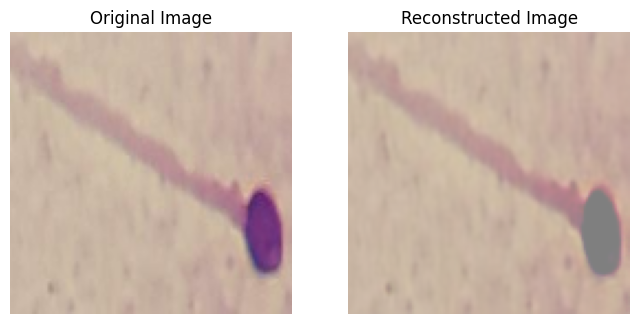

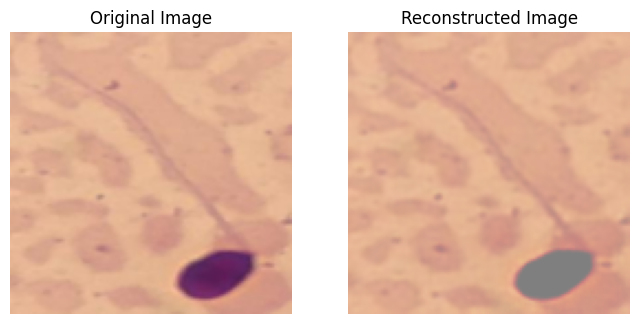

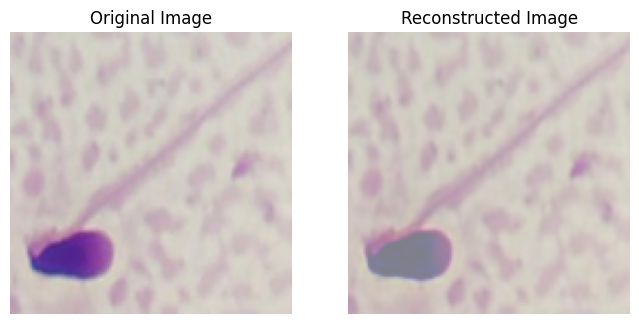

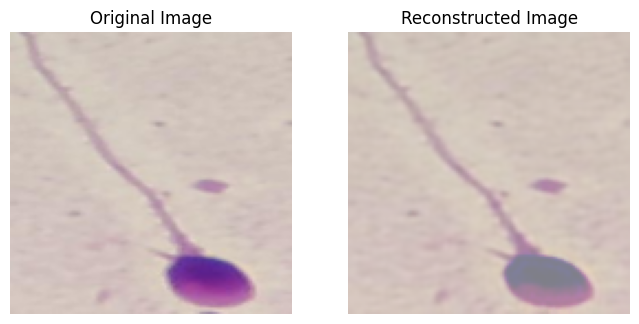

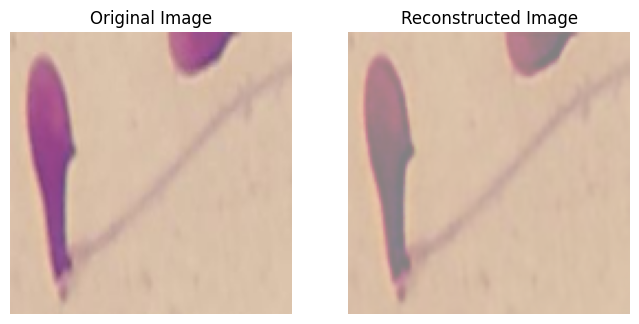

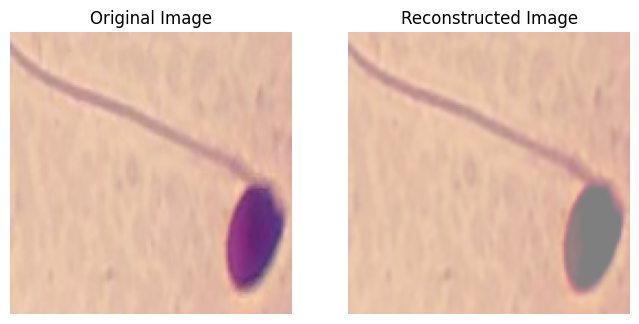

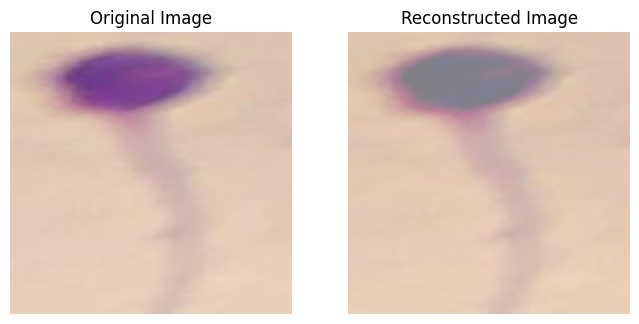

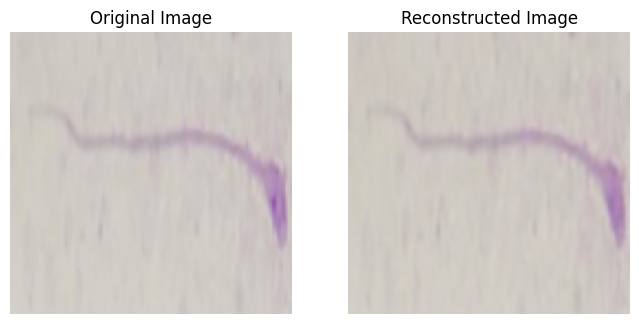

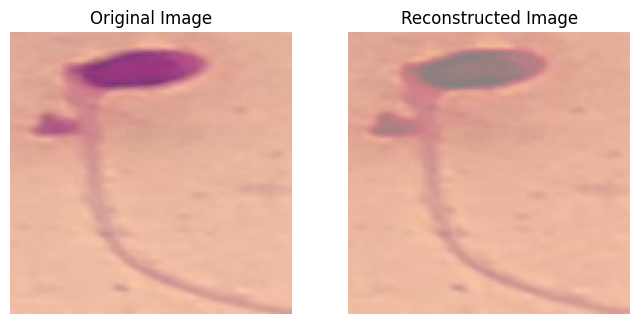

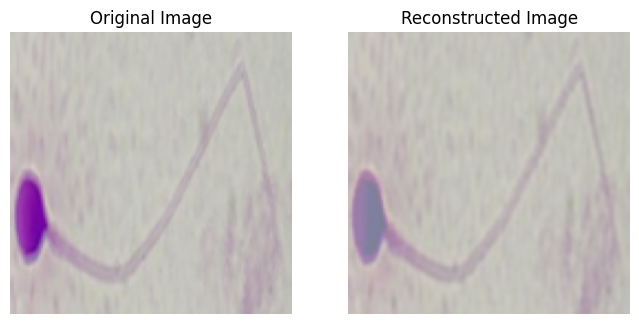

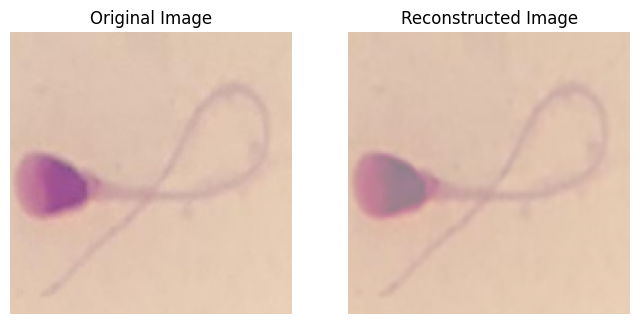

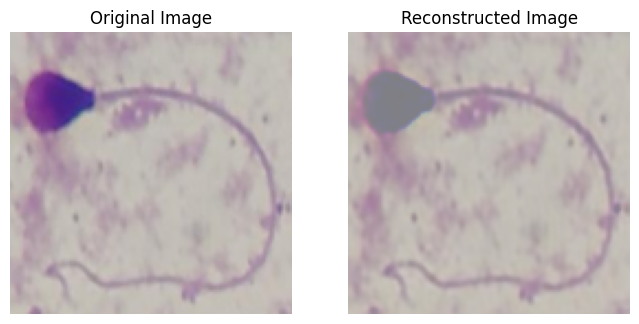

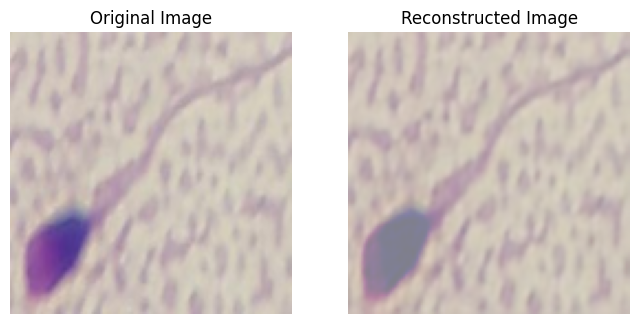

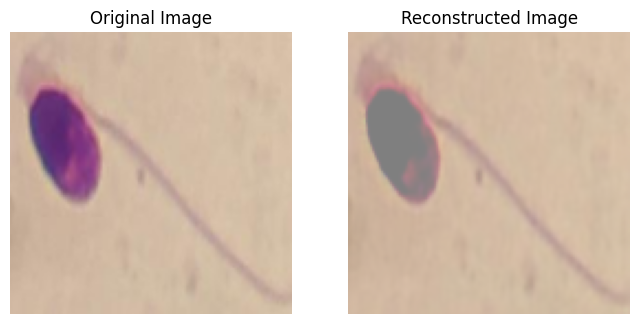

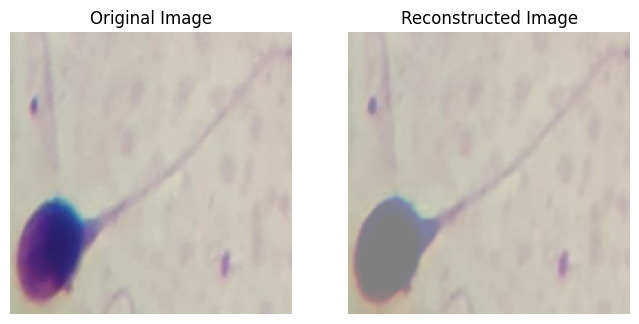

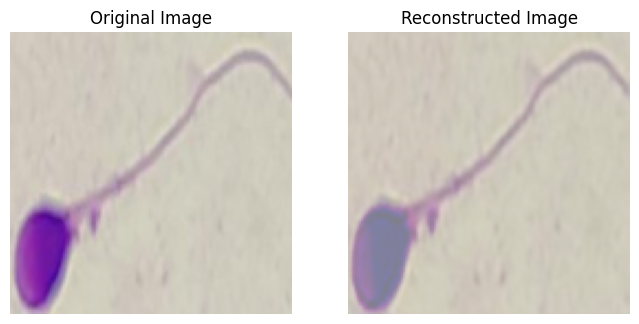

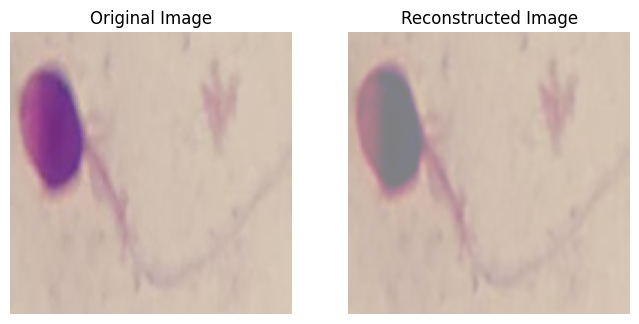

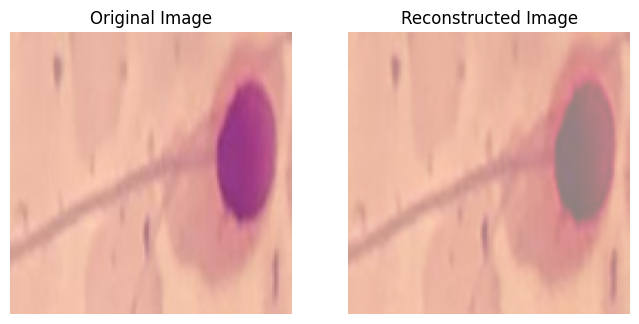

In [ ]:
def show_images(autoencoder, test_loader, device, num_images=5):
    autoencoder.eval()  # Model değerlendirme moduna alınır. Bu sayede Dropout, BatchNorm gibi katmanlar eğitim modundan çıkmış olur.

    with torch.no_grad():  # Bu blok içinde gradyan hesaplama devre dışı kalır; değerlendirme ve görselleştirme için hız ve bellek avantajı sağlar.
        for i, (inputs, _) in enumerate(test_loader):
            inputs = inputs.to(device)  # Giriş verisi GPU ya da CPU’ya (device) taşınır.
            outputs = autoencoder(inputs)  # Modelden çıktılar alınır. (Girdi görüntülerinin yeniden oluşturulmuş halleri)

            # Tensörleri (N, C, H, W) formatından (N, H, W, C) formatına çeviriyoruz.
            # Bu dönüşüm matplotlib ile görüntü göstermek için gereklidir.
            inputs = inputs.cpu().numpy().transpose(0, 2, 3, 1)   # (N, C, H, W) -> (N, H, W, C)
            outputs = outputs.cpu().numpy().transpose(0, 2, 3, 1) # Aynı dönüşüm çıktı için

            # Normalizasyonu geri al (Unnormalize):
            # Eğitimde normalization: (img - 0.5) / 0.5 yapıldı.
            # Dolayısıyla geri almak için: img * 0.5 + 0.5
            inputs = (inputs * 0.5) + 0.5
            outputs = (outputs * 0.5) + 0.5
            # Elde ettiğimiz veriler şu an [0,1] aralığında float değerler.
            # Bu değerleri direkt plt.imshow kullanarak gösterebiliriz.

            # Görselleştirme:
            # num_images parametresi kadar orijinal ve yeniden yapılandırılmış görüntü göstereceğiz.
            for j in range(min(num_images, len(inputs))):
                plt.figure(figsize=(8, 4))

                # Orijinal görüntü
                plt.subplot(1, 2, 1)
                plt.imshow(inputs[j])
                plt.title("Original Image")
                plt.axis("off")  # Eksenleri kapat.

                # Yeniden yapılandırılmış görüntü
                plt.subplot(1, 2, 2)
                plt.imshow(outputs[j])
                plt.title("Reconstructed Image")
                plt.axis("off")

                plt.show()

            # Her batch'te görüntülenen görüntü sayısını num_images'tan düşürüyoruz.
            num_images -= len(inputs)
            # Eğer hedeflenen görüntü sayısını aştıysak döngüyü kırıyoruz.
            if num_images <= 0:
                break


# Example usage:
show_images(autoencoder, test_loader, device, num_images=18)

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Giriş: 3 kanallı (RGB), Çıkış: 64 kanal
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Boyut yarıya iner: [64, 64, 64]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Çıkış: [128, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Boyut yarıya iner: [128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# Çıkış: [256, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   # Boyut yarıya iner: [256, 16, 16]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                           # [256, 16, 16] -> [256*16*16]
            nn.Linear(256 * 16 * 16, 512),                          # Tam bağlantılı katman
            nn.ReLU(),
            nn.Dropout(0.35),                                       # Dropout oranı %35
            nn.Linear(512, num_classes)                             # Sınıf sayısı kadar çıktı
        )

    def forward(self, x):
        x = self.features(x)    # Convolution + Pooling işlemlerinden geç
        x = self.classifier(x)  # Tam bağlantılı katmanlarda sınıflandırma yap
        return x

# __init__ metodunda bir dizi konvolüsyon ve maksimum havuzlama (max pooling) katmanından oluşan features bloğu tanımlanır. Girdi boyutunun başta [3, 128, 128] olduğu varsayılırsa, her pooling ile uzamsal boyut yarıya iner.
# classifier bloğu son aşamada elde edilen öz nitelikleri (features) vektörel hale getirir (Flatten) ve 2 tam bağlantılı katman + dropout kullanarak sınıflandırır.
# Dropout oranı 0.35 olarak belirlenmiştir, bu sayede overfitting’i azaltmak amaçlanmaktadır.


In [ ]:
class ReconstructedDataset(Dataset):
    def __init__(self, dataloader, autoencoder, device):
        self.images = []
        self.labels = []
        autoencoder.eval()  # Otoenkoder değerlendirme modunda (dropout, batchnorm sabitlenir)
        with torch.no_grad():  # Gradyan hesaplamayı kapat, sadece ileri geçiş yapılacak
            for inputs, labels in dataloader:
                inputs = inputs.to(device)        # dataloader içindeki tüm orijinal görüntüler alınır.
                reconstructed = autoencoder(inputs).cpu()  # autoencoder modeline gönderilerek yeniden yapılandırılmış sürümler elde edilir.
                self.images.append(reconstructed)
                self.labels.append(labels)        # Bu yeni görüntüler (self.images) ve etiketleri (self.labels) saklanır.
        # Listelerde biriken tensörleri birleştir
        self.images = torch.cat(self.images)  # [N, C, H, W] boyutunda tek bir tensör
        self.labels = torch.cat(self.labels)  # [N] boyutunda etiket tensörü

    def __len__(self):
        return len(self.images) # __len__ metodu dataset’in uzunluğunu döndürür.

    def __getitem__(self, idx):
        # Her çağrıldığında ilgili indexteki görüntü ve etiketi döndür
        return self.images[idx], self.labels[idx]

In [ ]:
reconstructed_train_dataset = ReconstructedDataset(train_loader, autoencoder, device)
reconstructed_test_dataset = ReconstructedDataset(test_loader, autoencoder, device)
# train_loader ve test_loader orijinal görüntüleri batch’ler halinde sağlarken, bu loader’lardaki veriler otoenkoderdan geçirilip yeni dataset’ler oluşturulur.

In [ ]:
# reconstructed_train_dataset ve reconstructed_test_dataset zaten elde edilmiş durumda.
reconstructed_train_loader = DataLoader(reconstructed_train_dataset, batch_size=32, shuffle=True)
reconstructed_test_loader = DataLoader(reconstructed_test_dataset, batch_size=32, shuffle=False)

# eğitim setine karıştırma eklemek için shuffle true yaparız.


In [ ]:
# Eğitim verisini train/validation olarak ayırma (80% train - 20% val)
train_size = int(0.80 * len(reconstructed_train_dataset))
val_size = len(reconstructed_train_dataset) - train_size
train_dataset, val_dataset = random_split(reconstructed_train_dataset, [train_size, val_size])


In [ ]:
# Ayrılan veri setleri için DataLoader oluşturma
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
num_classes = len(dataset.classes)  # Sınıf sayısını veri kümesinden al
cnn_classifier = CNNClassifier(num_classes).to(device)

# CNNClassifier: Önceden tanımlanmış bir CNN sınıflandırma modeli. Bu modeli GPU yada CPU'da çalışacak şekilde cihaza ayarlıyoruz.


In [ ]:
optimizer = optim.SGD(cnn_classifier.parameters(), lr=0.01, momentum=0.9, nesterov=True)
# optimizer: Öğrenme oranı 0.01, momentum 0.9, nesterov=True ile klasik SGD'nin geliştirilmiş bir versiyonu kullanılır.

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
# CosineAnnealingWarmRestarts her 5 epokta (T_0=5) bir öğrenme hızını yeniden başlatır, T_mult=2 ile her yeniden başlatmada periyodu iki katına çıkar.


In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion: Sınıflandırma görevlerinde yaygın olarak kullanılan çapraz entropi kaybı .


In [ ]:
patience = 15  # İyileşme olmazsa beklenilecek epoch sayısı
best_val_loss = float('inf')  # Başta en iyi validation kaybı çok büyük bir değere set edilir
epochs_no_improve = 0  # İyileşme olmadan geçen epoch sayısı
early_stop = False  # Erken durdurma tetikleyicisi

# Eğer 15 epoch boyunca validation loss iyileşmezse, early stopping devreye girecek.


In [ ]:
num_epochs = 40  # Eğitim epoch sayısı

for epoch in range(num_epochs):
    cnn_classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Eğitim döngüsü
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # İleri geçiş (Forward pass)
        outputs = cnn_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Cosine annealing warm restarts uygulamak için her epoch sonunda scheduler çağrılır.
    scheduler.step()

    # Validation verisi üzerinde model performansı ölçülür.
    # eval() moduna geçildiğinde dropout, batchnorm gibi katmanlar değerlendirme moduna döner.
    # val_loss ve val_accuracy hesaplanır.
    cnn_classifier.eval()  # Değerlendirme modu
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Değerlendirmede gradyan gerekmez
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_classifier(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {100.*correct/total:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
# Eğitim ve Validation Sonuçlarının Yazdırılması

    # Early stopping kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # gelişme görülürse sayacı sıfırla
        # modeli kaydet
        torch.save(cnn_classifier.state_dict(), 'sperm_cnn_classifier_best.pth')
        print("Validation loss improved. Model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered. No improvement for {} epochs.".format(patience))
        early_stop = True
        break  # Early stop triggerlanırsa eğitimden çıkış yap.
# Step 4: Test the classifier on the test set if early stopping didn't trigger
if not early_stop:
    cnn_classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in reconstructed_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_classifier(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100.*correct/total:.2f}%")

# Eğer early stopping tetiklenmediyse en son aşamada test seti üzerinde modelin performansı ölçülür.
# cnn_classifier.eval() ile değerlendirme moduna alınır.
# Test verisi üzerinde doğruluk hesaplanır.

Epoch [1/40], Train Loss: 2.5980, Train Accuracy: 17.56%, Val Loss: 2.5593, Val Accuracy: 20.06%
Validation loss improved. Model saved.
Epoch [2/40], Train Loss: 2.5350, Train Accuracy: 18.65%, Val Loss: 2.5439, Val Accuracy: 19.07%
Validation loss improved. Model saved.
Epoch [3/40], Train Loss: 2.4906, Train Accuracy: 18.90%, Val Loss: 2.5013, Val Accuracy: 19.21%
Validation loss improved. Model saved.
Epoch [4/40], Train Loss: 2.4250, Train Accuracy: 19.57%, Val Loss: 2.4449, Val Accuracy: 23.45%
Validation loss improved. Model saved.
Epoch [5/40], Train Loss: 2.3486, Train Accuracy: 24.23%, Val Loss: 2.4056, Val Accuracy: 24.72%
Validation loss improved. Model saved.
Epoch [6/40], Train Loss: 2.3046, Train Accuracy: 23.17%, Val Loss: 2.2925, Val Accuracy: 26.98%
Validation loss improved. Model saved.
Epoch [7/40], Train Loss: 2.2059, Train Accuracy: 25.47%, Val Loss: 2.2135, Val Accuracy: 27.54%
Validation loss improved. Model saved.
Epoch [8/40], Train Loss: 2.1479, Train Accuracy

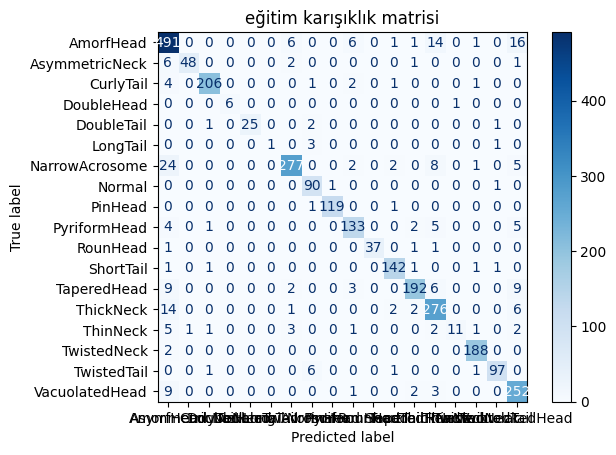

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Eğitim aşamasında
all_preds = []  # Tüm tahminleri saklamak için
all_labels = []  # Gerçek etiketleri saklamak için

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = cnn_classifier(inputs)
    _, predicted = outputs.max(1)

    # NumPy'ye dönüştür ve listeye ekle
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

# Confusion Matrix Görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("eğitim karışıklık matrisi")
plt.show()


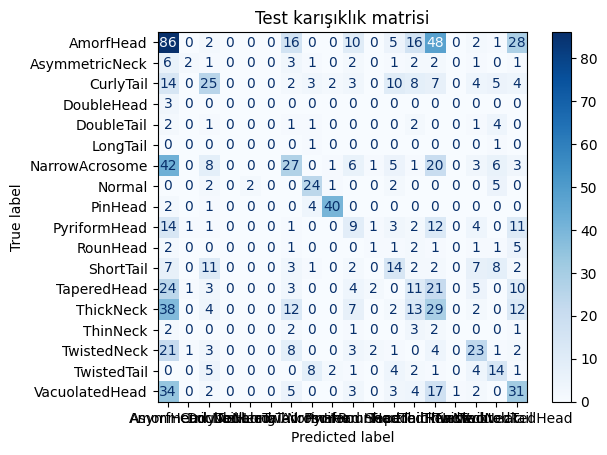

In [ ]:
# Test aşamasında
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in reconstructed_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_classifier(inputs)
        _, predicted = outputs.max(1)

        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Confusion Matrix Hesaplama
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

# Confusion Matrix Görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test karışıklık matrisi")
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

cnn_classifier.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in reconstructed_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_classifier(inputs)
        _, predicted = outputs.max(1)

        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
test_precision = precision_score(all_test_labels, all_test_preds, average='macro')
test_recall = recall_score(all_test_labels, all_test_preds, average='macro')
test_accuracy = accuracy_score(all_test_labels, all_test_preds)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")


Test Accuracy: 0.30
Test Precision: 0.26
Test Recall: 0.24
Test F1 Score: 0.24


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
